# Introduction
This python notebook will be used for testing out the NZN parameter sets

## Importing functions and parameter sets

In [1]:
from besos.parameters import wwr, RangeParameter, FieldSelector, FilterSelector, GenericSelector, Parameter, expand_plist
from besos.parameters import RangeParameter, CategoryParameter, expand_plist

from besos import eppy_funcs as ef
import besos.sampling as sampling
from besos.evaluator import EvaluatorEP
from besos.problem import EPProblem

import copy
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt

In [2]:
import os
import sys

#importing a pre-existing parameter set database
nzn_pathway='./parameter_set'
sys.path.append(nzn_pathway)

from architectural_parameters import architectural_parameters
# from comfort_parameters import comfort_parameters
from envelope_parameters import envelope_parameters
# from lighting_parameters import lighting_parameters
# from loads_parameters import loads_parameters
# from plant_parameters import heating_plant_parameters
# from plant_parameters import cooling_plant_parameters
# from renewable_parameters import renewable_parameters
# from system_parameters import system_parameters
# from system_parameters import FCU_parameters
# from system_parameters import VAV_parameters
# from system_parameters import CB_parameters

In [3]:
parameters=[]
defaults={}
inputs_metadata=[]

parameter_sets=[architectural_parameters,envelope_parameters]

for i in parameter_sets:
    parameters.extend(i()[0])
    defaults.update(i()[1])
    inputs_metadata.extend(i()[2])

/home/user/.local/lib/python3.7/site-packages/besos/parameters.py:425: FutureWarning: Use value_descriptors instead of value_descriptor.
  FutureWarning("Use value_descriptors instead of value_descriptor.")


In [4]:
# inputs_metadata

In [5]:
import NZN_output_set
from NZN_output_set import fuel_use
from NZN_output_set import end_use_breakdown
from NZN_output_set import metrics

In [6]:
outputs, outputs_metadata = fuel_use()
outputs1, outputs_metadata1 = end_use_breakdown()
outputs2, outputs_metadata2 = metrics()

outputs = outputs+outputs1+outputs2
outputs_metadata = outputs_metadata+outputs_metadata1+outputs_metadata2

In [7]:
len(outputs_metadata)

24

In [8]:
# Drop any metadata associated with dropped outputs (reference Sampling notebook to confirm which outputs to drop - they must match)

def remove_output_metadata(removed_output_metadata_list, output_metadata_list):
    for label in removed_output_metadata_list:
        for metadata in output_metadata_list:
            if metadata['Label'] == ("{} (ekWh/m2)".format(label)):
                print(label)
                output_metadata_list.remove(metadata)
            
    return output_metadata_list

Manually edit 'removed_output_metadata_list' to include all ouput metadata that should not be included.

In [9]:
removed_output_metadata_list = ['Gas:Facility','Heating:Electricity','Heating:Gas','Cooling:Electricity','ExteriorLights:Electricity', 
                        'InteriorEquipment:Gas', 'ExteriorEquipment:Electricity', 'ExteriorEquipment:Gas', 
                        'Fans:Electricity', 'Pumps:Electricity', 'HeatRejection:Electricity', 'Humidifier:Electricity', 'Humidifier:Gas', 
                        'WaterSystems:Electricity', 'WaterSystems:Gas', 'TED']
outputs_metadata = remove_output_metadata(removed_output_metadata_list, outputs_metadata)

Gas:Facility
Heating:Electricity
Heating:Gas
Cooling:Electricity
ExteriorLights:Electricity
InteriorEquipment:Gas
ExteriorEquipment:Electricity
ExteriorEquipment:Gas
Fans:Electricity
Pumps:Electricity
HeatRejection:Electricity
Humidifier:Electricity
Humidifier:Gas
WaterSystems:Electricity
WaterSystems:Gas
TED


In [10]:
len(outputs_metadata)

8

In [11]:
# Import the pickled inputs and results from Sampling Notebook
inputs = pd.read_pickle('overall_inputs.p')
results_EUI = pd.read_pickle('overall_results.p')

# Building Specific Metadata

In [12]:
default_building = ef.get_building('NZN_Retail_Stripmall_Default.idf')

In [13]:
# Get approximate floor area of building
def get_floor_area(model):
    prev_area = 0
    for surface in model.idfobjects['BUILDINGSURFACE:DETAILED']:
        if surface['Surface_Type'] == 'Floor':
            area = surface.area
            total_area = area + prev_area
            prev_area = total_area
    est_floor_area = (str(round(total_area)) + ' m2')
    return(est_floor_area)

est_floor_area = get_floor_area(default_building)
print(est_floor_area)

2090.0 m2


In [14]:
print(default_building.idfobjects['BUILDING'][0].Name)   # Use this to double check building type against model
print(default_building.idfobjects['SITE:LOCATION'][0].Name)  # Use this to double check building location against model

NZN_Retail_Strip_Mall
Victoria Int'l


In [15]:
# Reference picture of model
from IPython.display import Image
photo = Image("thumbnail.png")
# photo

Enter in building description here:

In [16]:
building_description = """"This one story strip mall has a consistent height of 5.18 m. It consists of two larger
stores and 8 smaller stores, for a total of 10 thermal zones. Each small store has 2 regular windows, a front door 
that has been modelled as a fixed window, and a regular backdoor. Each large store has the exact same layout as the
small store but is twice as big and has twice the amount of windows, front doors, and back doors."""

Define building metadata in dictionary below. Fields can all be entered manually if desired.

In [17]:
model_attributes = {
    "Building Type" : "Retail Strip Mall",
    "Location" : "Victoria, BC",
    "Estimated Floor Area" : est_floor_area,
    "Photo" : photo,
    "Description": building_description
    }

In [18]:
# model_attributes

# Surrogate Model
A surrogate model will be used to speed up the analysis process. After the initial sampling, the surrogate will be used to do a massive re-sampling to feed into our statistics.

The general steps to create a surrogate model are:
- Create the general architecture
- Identify hyper-parameters
- Normalize the inputs
- Normalize the outputs
- Split to training & testing set
- Train the ML model
- Validate

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LeakyReLU


Couldn't import dot_parser, loading of dot files will not be possible.


## One Hot Encoding
We need to convert our categorical values in one-hot encoded columns for non-ordinal ML training.

In [20]:
inputs_onehot=pd.get_dummies(inputs)
inputs_onehot

North Window to Wall Ratio (%)  East Window to Wall Ratio (%)  \
0                         0.050399                       0.886532   
1                         0.174554                       0.289247   
2                         0.535935                       0.469717   
3                         0.205911                       0.314229   
4                         0.593789                       0.835909   
5                         0.950838                       0.005515   
6                         0.395285                       0.703158   
7                         0.140198                       0.682603   
8                         0.766009                       0.106026   
9                         0.068906                       0.540420   
10                        0.408298                       0.978366   
11                        0.602232                       0.895790   
12                        0.492053                       0.590683   
13                        0.856094                       0.599355   
14                        0.317947                       0.093858   
15                        0.652803                       0.247222   
16                        0.912153                       0.187546   
17                        0.258876                       0.415911   
18                        0.717824                       0.370650   
19                        0.825108                       0.765033   

    South Window to Wall Ratio (%)  West Window to Wall Ratio (%)  \
0                         0.880288                       0.911203   
1                         0.220157                       0.328804   
2                         0.178208                       0.187556   
3                         0.110264                       0.622139   
4                         0.583578                       0.965132   
5                         0.747345                       0.670703   
6                         0.354685                       0.587567   
7                         0.968954                       0.780741   
8                         0.664075                       0.129851   
9                         0.015652                       0.850554   
10                        0.806812                       0.410195   
11                        0.636827                       0.098878   
12                        0.725962                       0.286798   
13                        0.057040                       0.017702   
14                        0.457784                       0.227764   
15                        0.256745                       0.446823   
16                        0.402829                       0.792367   
17                        0.505820                       0.696942   
18                        0.346309                       0.520042   
19                        0.899452                       0.381564   

    North Shading (m)  East Shading (m)  South Shading (m)  West Shading (m)  \
0            0.419453          0.158337           0.503700          1.890747   
1            0.540337          0.631510           1.277153          0.527508   
2            1.246718          1.194576           1.493445          0.477991   
3            0.684800          1.237545           1.865886          0.624544   
4            1.616344          1.934798           0.872143          1.718958   
5            1.559917          0.013978           0.766117          1.516655   
6            0.984202          0.209170           0.948356          1.213347   
7            0.135387          1.082777           0.474937          1.958762   
8            0.835549          0.518806           1.690092          0.078470   
9            0.051913          1.704154           1.146733          1.689838   
10           1.379909          1.510817           0.347545          0.794611   
11           1.920136          1.885667           1.376373          1.304377   
12           1.148888          0.347902           1.727621      

## Train-Test Split
We'll do 80/20 train/test split here

In [21]:
train_in, test_in, train_out, test_out = train_test_split(inputs_onehot, results_EUI, test_size=0.2)

## Normalization of inputs

To ensure an equal weighting of inputs and outputs in the backpropagation algorithm fitting the neural network, we have to normalize the input values.   
Different options for normalization exist.  
Here we bring all features (input variables) to have zero mean and a standarddeviation of 1.  
Note that we fit the normalizer on training data only.

In [22]:
scaler_in = StandardScaler()
NN_inputs = scaler_in.fit_transform(X=train_in)
NN_inputs_test=scaler_in.transform(X=test_in)

scaler_out = StandardScaler()
NN_outputs = scaler_out.fit_transform(X=train_out+0.00001)
NN_outputs_test=scaler_out.transform(X=test_out+0.00001)

In [23]:
# NN_outputs

## Build the Model
Using the keras functional API, we will build a relatively simple deep neural network

In [24]:
#This matches the number of parameter inputs we have to enter as the input layer into the NN
num_inputs = len(inputs_onehot.columns)
print(f'Number of inputs: {num_inputs}')
#This matches the number of model outputs we have to enter as the output layer into the NN
num_outputs = len(results_EUI.columns)
print(f'Number of inputs: {num_outputs}')

Number of inputs: 19
Number of inputs: 8


In [25]:
results_EUI

Electricity:Facility  DistrictHeating:Facility  DistrictCooling:Facility  \
0              33.751775                 52.386558                 24.094319   
1              37.554675                264.201724                 10.534897   
2              53.177714                 55.324308                 23.125097   
3              58.128310                153.427883                 10.733623   
4              33.474842                183.878216                 14.696014   
5              32.978480                 67.099807                 30.020294   
6              35.504777                 53.303004                  7.223336   
7              32.871260                 81.862606                  7.804849   
8              33.455991                353.467174                 21.642686   
9              55.582145                230.601388                 10.478989   
10             32.992920                185.670391                 21.882017   
11             33.655113                135.151468                  5.094455   
12             33.692792                 79.112727                  8.488141   
13             46.372388                142.820819                  9.657044   
14             33.536916                277.288426                 10.872815   
15             35.761317                 78.078818                 10.445189   
16             35.982646                 69.717536                 11.655566   
17             33.071399                 64.869919                 18.205522   
18             36.502286                241.902961                 13.873029   
19             32.799340                408.122933                 20.312265   

    Heating:DistrictHeating  Cooling:DistrictCooling  \
0                 52.386558                24.094319   
1                264.201724                10.534897   
2                 55.324308                23.125097   
3                153.427883                10.733623   
4                183.878216                14.696014   
5                 67.099807                30.020294   
6                 53.303004                 7.223336   
7                 81.862606                 7.804849   
8                353.467174                21.642686   
9                230.601388                10.478989   
10               185.670391                21.882017   
11               135.151468                 5.094455   
12                79.112727                 8.488141   
13               142.820819                 9.657044   
14               277.288426                10.872815   
15                78.078818                10.445189   
16                69.717536                11.655566   
17                64.869919                18.205522   
18               241.902961                13.873029   
19               408.122933                20.312265   

    InteriorLights:Electricity  InteriorEquipment:Electricity         TEU  
0                    23.647552                      10.104222  110.232651  
1                    27.450452                      10.104222  312.291296  
2                    43.073492                      10.104222  131.627119  
3                    48.024087                      10.104222  222.289816  
4                    23.370620                      10.104222  232.049073  
5                    22.874258                      10.104222  130.098581  
6                    25.400555                      10.104222   96.031117  
7                    22.767037                      10.104222  122.538714  
8                    23.351769                      10.104222  408.565851  
9                    45.477923                      10.104222  296.662522  
10                   22.888698                      10.104222  240.545327  
11                   23.550891                      10.104222  173.901035  
12                   23.588570                      10.104222  121.293660  
13                   36.268166                      10.104222  198.850251  
14    

In [26]:
#Create a 4-layer model, with 2 middle layers both with nodes that are 16*the number of inputs
#The hidden layers are activated with ReLU function.
# Since we are performing regression we do not want an activation for the output. 
#The output has been normalized to 0 +/- 1 std, and a ReLU activation function only returns positive numbers.
#We will use an L2 regularizer to help prevent overfitting. For now we will use the default alpha 0.01.

input_layer = keras.Input(shape=(num_inputs,))

#first hidden layer
dense_1 = layers.Dense(units=num_inputs*5, kernel_regularizer='l1_l2')(input_layer)
activation_1=layers.LeakyReLU()(dense_1)
#second hidden layer
dense_2 = layers.Dense(units=num_inputs*5, kernel_regularizer='l1_l2')(activation_1)
activation_2=layers.LeakyReLU()(dense_2)
#third hidden layer
dense_3 = layers.Dense(units=num_inputs*5, kernel_regularizer='l1_l2')(activation_2)
activation_3=layers.LeakyReLU()(dense_3)


#output layer
output_layer = layers.Dense(units=num_outputs)(activation_3)

model=models.Model(inputs=input_layer,outputs=output_layer)

In [27]:
print(model.summary())
# plot_model(model)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
dense (Dense)                (None, 95)                1900      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 95)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 95)                9120      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 95)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 95)                9120      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 95)               

## Hyper-parameters

Before we start fitting the NN model we define the set of hyperparameters we want to analyse in our cross-validation to optimize the model.  
Here, we select the number of layers of the network as well as the regularization parameter alpha as parameter value.  
A larger number of layers and a lower value of the regularizer lead to higher variance of the network.  
This may lead to overfitting.  
The best selection may be found using an optimizer like Bayesian Optimization.  
In this example we use a simple grid search.

## Training

Here we will compile and train the model.

In [28]:
loss = 'mean_squared_error'
optimizer = 'adam'
metrics=['mae', 'mse']

model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

In [29]:
history=model.fit( x=NN_inputs, y=NN_outputs, batch_size = 256,epochs=1000)
test_scores = model.evaluate(NN_inputs_test, NN_outputs_test, verbose=2)
print("Test MAE:", test_scores[0])
print("Test MSE:", test_scores[1])

Epoch 1/1000
1/1 [==============================] - 0s 1ms/step - loss: 21.4636 - mae: 0.8095 - mse: 1.0960
Epoch 2/1000
1/1 [==============================] - 0s 1ms/step - loss: 21.2016 - mae: 0.7942 - mse: 1.0427
Epoch 3/1000
1/1 [==============================] - 0s 926us/step - loss: 20.9460 - mae: 0.7809 - mse: 0.9955
Epoch 4/1000
1/1 [==============================] - 0s 972us/step - loss: 20.6964 - mae: 0.7697 - mse: 0.9541
Epoch 5/1000
1/1 [==============================] - 0s 989us/step - loss: 20.4520 - mae: 0.7596 - mse: 0.9179
Epoch 6/1000
1/1 [==============================] - 0s 971us/step - loss: 20.2121 - mae: 0.7501 - mse: 0.8858
Epoch 7/1000
1/1 [==============================] - 0s 917us/step - loss: 19.9761 - mae: 0.7417 - mse: 0.8573
Epoch 8/1000
1/1 [==============================] - 0s 889us/step - loss: 19.7436 - mae: 0.7337 - mse: 0.8321
Epoch 9/1000
1/1 [==============================] - 0s 921us/step - loss: 19.5140 - mae: 0.7264 - mse: 0.8094
Epoch 10/1000


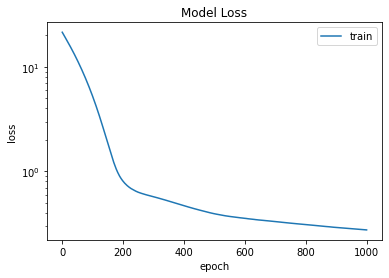

In [30]:
fig = plt.figure()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

## Evaluate test set
Evaluate the test set using the NN and the actual values

In [31]:
test_eval=model(NN_inputs_test,training=False)
test_eval=scaler_out.inverse_transform(test_eval)
test_eval_df=pd.DataFrame(test_eval,columns=results_EUI.columns)

In [32]:
# test_eval_df
# test_out

## Visually Compare the test dataset

In [33]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

In [35]:
mask = test_eval_df.isnull().values.sum(axis=1)==1
print(mask.sum())

0


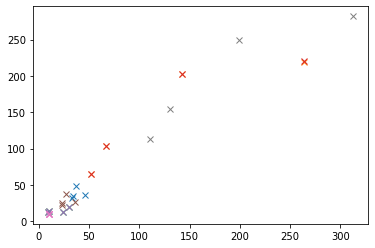

In [36]:
_=[plt.plot(test_out.iloc[:,i], test_eval_df.iloc[:,i],'x') for i in range(num_outputs)]
print()

[-8.56225394e-01  7.49681954e-01  1.38280854e-01  7.49672217e-01
  1.44199811e-01 -8.29906129e-01 -2.91836902e+19  8.37503021e-01]



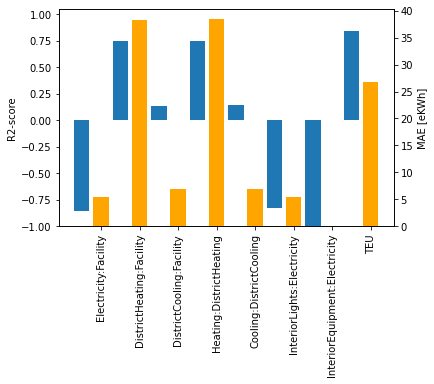

In [37]:
outputs=results_EUI.columns

plt.bar(range(0,len(outputs)*2,2),r2_score(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'))
plt.ylim([-1,1.05])
ax = plt.gca()
ax2=ax.twinx()

ax2.bar(range(1,len(outputs)*2,2),
        mean_absolute_error(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'),
       color='orange')

ax.set_xticks(range(1,len(outputs)*2,2))
_=ax.set_xticklabels(outputs, rotation=90)
ax.set_ylabel('R2-score')
ax2.set_ylabel('MAE [eKWh]')
plt.grid=False
print(r2_score(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'))
print()

In [38]:
results_EUI.columns
end_uses=results_EUI.columns[2:-2]

This plotly chart is an interactive chart that will show the end-use breakdown in bar charts. It compares the results of a NN and the original E+ simulations.

In [39]:
# traces=[]
# buttons=[dict(label = "All",
#                  method = "update",
#                  args = [{"visible": True}])]

# for row in test_eval_df.index.to_list():
#     visibles=[False]*len(test_eval_df.index)
#     visibles[row]=True
    
#     traces.append(
#         go.Bar(
#             x = end_uses,
#             y = test_eval_df.iloc[row][end_uses],
#             name = (f"NN: {row}"),
#             yaxis="y2"
#         ))
    
#     buttons.append(
#     dict(label = str(row),
#                  method = "update",
#                  args = [{"visible": visibles}])
#     )
    
# for row in test_eval_df.index.to_list():
   
#     traces.append(
#         go.Bar(
#             x = end_uses,
#             y = test_out.iloc[row][end_uses],
#             name = (f"E+: {row}"),
#             yaxis="y2"
            
#         ))   
    
# for row in test_eval_df.index.to_list():
   
#     traces.append(
#         go.Table(
#             header=dict(
#                 values=test_in.columns,
#                 font=dict(size=10),
#                 align="left"
#             ),
#             cells=dict(
#                 values=test_in.iloc[row].tolist(),
#                 align = "left")
#         ))    

    
# updatemenus=[dict(active=-1,
#          buttons=buttons)]
    
# layout = dict(title="Dropdown",
#               showlegend=True,
#               xaxis=dict(title="Source"),
#               yaxis=dict(title="Number", range=(-5, test_eval_df[end_uses].max().max()*1.1)),
#               updatemenus=updatemenus,
#               height=600)

# fig = make_subplots(rows=2,cols=1,
#                    row_heights=[.3,.7])
                         
# fig.add_traces(traces)
# fig.update_layout(layout)
# fig.show()

We've noticed that the main parameters affected by this parameter set are the heating:gas, and humidifier:electricity parameters. Let's look at R2 plots for these two parameters

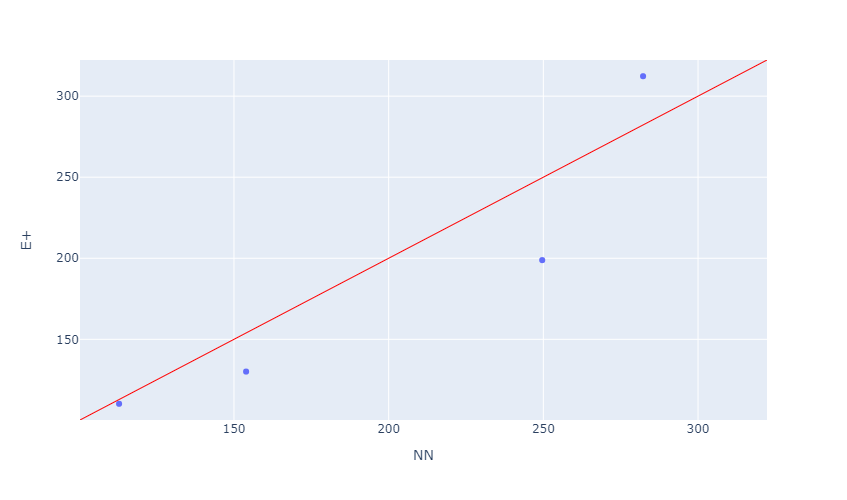

In [40]:
#Scatter subplots of NN vs E+ results

#for now we will do it quickly with express
import plotly.express as px


# traces=[]

# traces.append(
#     go.Scatter(x=test_eval_df['Heating:Gas'],
#               y=test_in['Heating:Gas']))

variable='TEU'
min_range=test_out[variable].min()-10
max_range=test_out[variable].max()+10

fig = px.scatter(x=test_eval_df[variable],y=test_out[variable])
fig.update_layout(
        yaxis=dict(range=[min_range,max_range]),
        xaxis=dict(range=[min_range,max_range]),
        xaxis_title='NN',
        yaxis_title='E+',
        height=500,
        width=500)

fig.add_shape(
        # 1-1 Line
        dict(
            type="line",
            x0=min_range,
            y0=min_range,
            x1=max_range,
            y1=max_range,
            line=dict(
                color="Red",
                width=1
            )))
fig.show()

In [41]:
# #Scatter subplots of NN vs E+ results

# #for now we will do it quickly with express
# import plotly.express as px


# # traces=[]

# # traces.append(
# #     go.Scatter(x=test_eval_df['Heating:Gas'],
# #               y=test_in['Heating:Gas']))

# variable='Cooling:Electricity'
# min_range=test_out[variable].min()-10
# max_range=test_out[variable].max()+10

# fig = px.scatter(x=test_eval_df[variable],y=test_out[variable])
# fig.update_layout(
#         yaxis=dict(range=[min_range,max_range]),
#         xaxis=dict(range=[min_range,max_range]),
#         xaxis_title='NN',
#         yaxis_title='E+',
#         height=500,
#         width=500)

# fig.add_shape(
#         # 1-1 Line
#         dict(
#             type="line",
#             x0=min_range,
#             y0=min_range,
#             x1=max_range,
#             y1=max_range,
#             line=dict(
#                 color="Red",
#                 width=1
#             )))
# fig.show()

# Store metadata

In [42]:
results_EUI.columns=['Electricity:Facility [ekWh/m2]', 'DistrictHeating:Facility [ekWh/m2]',
       'DistrictCooling:Facility [ekWh/m2]', 'Heating:DistrictHeating [ekWh/m2]',
       'Cooling:DistrictCooling [ekWh/m2]', 'InteriorLights:Electricity [ekWh/m2]',
       'InteriorEquipment:Electricity [ekWh/m2]', 'TEU [ekWh/m2]']

In [43]:
inputs_dataframe = inputs_onehot
inputs_index = inputs_onehot.columns
outputs_dataframe = results_EUI
outputs_index = results_EUI.columns
inputs_scaler = scaler_in
outputs_scaler = scaler_out

In [44]:
all_model_metadata = {"inputs_index": inputs_index,
                      "inputs_metadata": inputs_metadata,
                      "model_attributes": model_attributes,
                      "outputs_index": outputs_index,
                      "outputs_metadata": outputs_metadata,
                      "inputs_scaler": inputs_scaler,
                      "outputs_scaler": outputs_scaler,
                      "inputs_dataframe": inputs_dataframe,
                      "outputs_dataframe": outputs_dataframe}

In [45]:
import pickle
pickle.dump(all_model_metadata, open('model_pickle','wb'))

# Store model

In [46]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Tensorflow js model

In [47]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'model_new')

/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:123: H5pyDeprecationWarning:

The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.



In [48]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)